In [14]:
from __future__ import print_function
import pandas as pd
import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
 
from model import PMF
from evaluations import RMSE

In [16]:
data_df = pd.read_csv('dataset/eComm-sample-data2.csv')
print(data_df.shape)

(125534, 13)


In [17]:
data_df.head(2)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,cat_1,cat_2,user_id_num,product_id_num
0,1569888134000000000,purchase,1004856,2053013555631882655,electronics.smartphone,samsung,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564,electronics,smartphone,3796,613
1,1569896511000000000,cart,1005135,2053013555631882655,electronics.smartphone,apple,1747.79,515384420,7f82b450-6c45-4346-96fb-ecf4ab25779c,electronics,smartphone,1811,817


In [18]:
data_df.event_type.value_counts()

view        63267
cart        33549
purchase    28718
Name: event_type, dtype: int64

In [19]:
(63267 + 33549*4 + 28718*6)/len(data_df)

2.9455844631733235

In [20]:
data_df.event_type.value_counts() / len(data_df)

view        0.503983
cart        0.267250
purchase    0.228767
Name: event_type, dtype: float64

In [21]:
event_type_to_num = {'view': 1.0, 'cart': 2.0, 'purchase': 3.0}
data_df['behavior'] = data_df['event_type'].apply(lambda x : event_type_to_num[x])

In [22]:
NUM_USERS, NUM_ITEMS = data_df.user_id_num.nunique(), data_df.product_id_num.nunique()

In [23]:
print(NUM_USERS, NUM_ITEMS)

5309 15184


In [24]:
data = data_df.loc[:, ['user_id_num', 'product_id_num', 'behavior']]

In [25]:
data.shape

(125534, 3)

In [26]:
data.behavior.unique()

array([3., 2., 1.])

In [27]:
# --------------------------------------------- HYPERPARAMETERS ----------------------------------------------------
# Input batch size for training
batch_size = 256
# Number of maximum epoches to train
epoches = 25
# Enables CUDA training
use_cuda = False
# Generate random seed
seed = 1
# Weight decay
weight_decay = 0.1
# Size of embedding features
embedding_feature_size = 100
# Training ratio
ratio = 0.8
# Learning rate
lr = 0.0001
# Momentum value
momentum = 0.9

In [28]:
# Shuffle data
data = shuffle(data)
data.reset_index(drop=True, inplace=True)
# Split data
train_data = data.loc[:int(ratio*data.shape[0])]
vali_data = data.loc[int(ratio*data.shape[0]):int((ratio+(1-ratio)/2)*data.shape[0])]
test_data = data.loc[int((ratio+(1-ratio)/2)*data.shape[0]):]

In [29]:
train_data.shape, vali_data.shape, test_data.shape

((100428, 3), (12554, 3), (12554, 3))

In [30]:
train_data.behavior.value_counts()

1.0    50675
2.0    26853
3.0    22900
Name: behavior, dtype: int64

In [31]:
vali_data.behavior.value_counts()

1.0    6259
2.0    3393
3.0    2902
Name: behavior, dtype: int64

In [32]:
test_data.behavior.value_counts()

1.0    6333
2.0    3304
3.0    2917
Name: behavior, dtype: int64

In [33]:
X_train, y_train = train_data.loc[:, ['user_id_num', 'product_id_num']].values, train_data.loc[:, ['behavior']].values
X_valid, y_valid = vali_data.loc[:, ['user_id_num', 'product_id_num']].values, vali_data.loc[:, ['behavior']].values
X_test, y_test = test_data.loc[:, ['user_id_num', 'product_id_num']].values, test_data.loc[:, ['behavior']].values

In [34]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda and use_cuda else "cpu")

In [35]:
torch.manual_seed(seed=seed)
if cuda:
    torch.cuda.empty_cache()
    torch.cuda.manual_seed(seed=seed)

In [36]:
kwargs = {'num_workers':2, 'pin_memory':True} if cuda else {}

In [37]:
class EcommDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        assert self.X.shape[0] == self.y.shape[0]
        self.transform = transform
        pass
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return (self.X[idx], self.y[idx])

In [38]:
train_dataset = EcommDataset(X_train, y_train)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, **kwargs)

In [39]:
valid_dataset = EcommDataset(X_valid, y_valid)
vald_data_loader = DataLoader(valid_dataset, batch_size=len(X_valid), shuffle=False, **kwargs)
valid_data = next(iter(vald_data_loader))

In [40]:
test_dataset = EcommDataset(X_test, y_test)
test_data_loader = DataLoader(test_dataset, batch_size=len(X_test), shuffle=False, **kwargs)
test_data = next(iter(test_data_loader))

In [41]:
# Initialize model
model = PMF(n_users=NUM_USERS, n_items=NUM_ITEMS, n_factors=embedding_feature_size, no_cuda=use_cuda)
 
# Move model to CUDA if CUDA selected
if cuda:
    model.cuda()
    print("Model moved to CUDA")
 
# Set loss function
loss_function = nn.MSELoss(reduction='sum')
 
# Set optimizer (uncomment Adam for adam)
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)

In [28]:
print(f"total batches {len(train_data_loader)}")

total batches 393


In [29]:
def train(epoch, train_data_loader):
    # Initialize
    model.train()
    epoch_loss = 0.0
    optimizer.zero_grad()
 
    # Go through batches
    for batch_idx, ele in enumerate(train_data_loader):
        # Zero optimizer gradient
        optimizer.zero_grad()
 
        # Extract user_id_nums: row, item_id_nums: col, ratings: val
        row = ele[0][:,0]
        col = ele[0][:,1]
        val = ele[1].squeeze()
         
        # Set to variables
        row = Variable(row.long())
        if isinstance(col, list):
            col = tuple(Variable(c.long()) for c in col)
        else:
            col = Variable(col.long())
        val = Variable(val.float())
 
        # Move data to CUDA
        if cuda:
            row = row.cuda()
            col = col.cuda()
            val = val.cuda()
 
        # Train
        preds = model.forward(row, col)
        loss = loss_function(preds, val)
        loss.backward()
        optimizer.step()
 
        # Update epoch loss
        epoch_loss += loss.item()
        
        print(f"Epoch {epoch}, batch_idx {batch_idx}, epoch_loss {loss.item()}", end='\r')
 
    epoch_loss /= len(train_data_loader.dataset)
    return epoch_loss


In [30]:
print('------------------------------------------- Training Model------------------------------------------------')
train_loss_list = []
last_vali_rmse = None
train_rmse_list = []
vali_rmse_list = []
print('parameters are: train ratio:{:f},batch_size:{:d}, epoches:{:d}, weight_decay:{:f}'.format(ratio, batch_size, epoches, weight_decay))
print(model)
 
# Go through epochs
for epoch in range(1, epoches+1):
 
    # Train epoch
    train_epoch_loss = train(epoch, train_data_loader)
 
    # Get epoch loss
    train_loss_list.append(train_epoch_loss)
 
    # Move validation data to CUDA
    if cuda:
        vali_row = Variable(valid_data[0][:,0]).long().cuda()
        vali_col = Variable(valid_data[0][:,1]).long().cuda()
    else:
        vali_row = Variable(valid_data[0][:,0]).long()
        vali_col = Variable(valid_data[0][:,1]).long()
 
    # Get validation predictions
    vali_preds = model.predict(vali_row, vali_col)
 
    # Calculate train rmse loss
    train_rmse = np.sqrt(train_epoch_loss)
 
    # Calculate validation rmse loss
    if cuda:
        vali_rmse = RMSE(vali_preds.cpu().data.numpy(), valid_data[1].cpu().data.numpy())
    else:
        vali_rmse = RMSE(vali_preds.data.numpy(), valid_data[1].data.numpy())
 
    # Add losses to rmse loss lists
    train_rmse_list.append(train_rmse)
    vali_rmse_list.append(vali_rmse)
 
    print('Training epoch:{: d}, training rmse:{: .6f}, vali rmse:{:.6f}'. \
              format(epoch, train_rmse, vali_rmse))
 
    # Early stop condition
    if last_vali_rmse and last_vali_rmse < vali_rmse:
        break
    else:
        last_vali_rmse = vali_rmse
 

------------------------------------------- Training Model------------------------------------------------
parameters are: train ratio:0.800000,batch_size:256, epoches:25, weight_decay:0.100000
PMF(
  (user_embeddings): Embedding(5309, 100)
  (item_embeddings): Embedding(15184, 100)
  (ub): Embedding(5309, 1)
  (ib): Embedding(15184, 1)
)
Training epoch: 1, training rmse: 1.359177, vali rmse:1.358238
Training epoch: 2, training rmse: 1.099793, vali rmse:1.295821
Training epoch: 3, training rmse: 1.002776, vali rmse:1.265782
Training epoch: 4, training rmse: 0.946435, vali rmse:1.247032
Training epoch: 5, training rmse: 0.908525, vali rmse:1.233811
Training epoch: 6, training rmse: 0.880957, vali rmse:1.223878
Training epoch: 7, training rmse: 0.859939, vali rmse:1.216112
Training epoch: 8, training rmse: 0.843391, vali rmse:1.209866
Training epoch: 9, training rmse: 0.830051, vali rmse:1.204727
Training epoch: 10, training rmse: 0.819097, vali rmse:1.200420
Training epoch: 11, training

In [43]:
model.load_state_dict(torch.load('trained/eComm_ratio_0.800000_bs_256_e_25_wd_0.100000_lr_0.000100_trained_pmf.pt'))

<All keys matched successfully>

In [ ]:
PMF(

In [44]:
# Move test set to CUDA
if cuda:
    test_row = Variable(test_data[0][:, 0]).long().cuda()
    test_col = Variable(test_data[0][:, 1]).long().cuda()
else:
    test_row = Variable(test_data[0][:, 0]).long()
    test_col = Variable(test_data[0][:, 1]).long()

preds = model.predict(test_row, test_col)
 
# Get test rmse loss
if cuda:
    test_rmse = RMSE(preds.cpu().data.numpy(), test_data[1].data.numpy())
else:
    test_rmse = RMSE(preds.data.numpy(), test_data[1].data.numpy())
print('Test rmse: {:f}'.format(test_rmse))
 
# Create plots
plt.figure(1)
plt.plot(range(1, len(train_rmse_list)+1), train_rmse_list, color='r', label='train rmse')
plt.plot(range(1, len(vali_rmse_list)+1), vali_rmse_list, color='b', label='test rmse')
plt.legend()
plt.annotate(r'train=%f' % (train_rmse_list[-1]), xy=(len(train_rmse_list), train_rmse_list[-1]),
             xycoords='data', xytext=(-30, 30), textcoords='offset points', fontsize=10,
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3, rad=.2'))
plt.annotate(r'vali=%f' % (vali_rmse_list[-1]), xy=(len(vali_rmse_list), vali_rmse_list[-1]),
             xycoords='data', xytext=(-30, 30), textcoords='offset points', fontsize=10,
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3, rad=.2'))
plt.xlim([1, len(train_rmse_list)+10])
plt.xlabel('iterations')
plt.ylabel('RMSE')
plt.title('RMSE Curve in Training Process')
plt.savefig('RMSE-Curve-PMF-yelp.png')
plt.show()
 

Test rmse: 1.164026


NameError: name 'train_rmse_list' is not defined

<Figure size 432x288 with 0 Axes>

In [32]:
# Save model
path_to_trained_pmf = 'trained/eComm_ratio_{:f}_bs_{:d}_e_{:d}_wd_{:f}_lr_{:f}_trained_pmf.pt'.format(ratio, batch_size, len(train_rmse_list), weight_decay, lr)
torch.save(model.state_dict(), path_to_trained_pmf)

In [46]:
preds.shape

torch.Size([12554])

In [50]:
torch.min(preds), torch.max(preds), torch.median(preds)

(tensor(0.0322, grad_fn=<MinBackward1>),
 tensor(3.0053, grad_fn=<MaxBackward1>),
 tensor(1.3019, grad_fn=<MedianBackward0>))

In [58]:
preds[preds<2].shape[0] / preds.shape[0]

0.7373745419786523

(array([4743.,    0.,    0.,    0.,    0., 4514.,    0.,    0.,    0.,
        3297.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

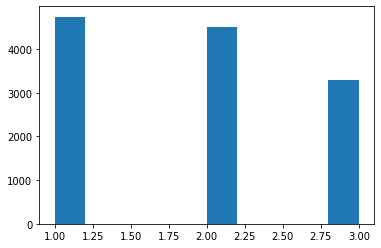

In [84]:
plt.hist(np.where(p<=1, 1, np.where(p<=2, 2, 3)))

In [81]:
np.where(p<=1, 1, np.where(p<=2, 2, 3))

array([3, 1, 3, ..., 1, 2, 1])

In [75]:
np.mean(act)

1.72789549147682

In [64]:
p = preds.detach().numpy()

In [65]:
act = test_data[1].squeeze().numpy()

In [72]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

In [82]:
mean_absolute_error(np.where(p<=1, 1, np.where(p<=2, 2, 3)), act)

0.4549944240879401

In [83]:
mean_absolute_percentage_error(np.where(p<=1, 1, np.where(p<=2, 2, 3)), act)

0.24214061919175825

(array([ 857., 2069., 1466., 1405., 1604., 1173., 1085., 1908.,  904.,
          83.]),
 array([0.03217772, 0.32949135, 0.626805  , 0.92411864, 1.2214323 ,
        1.5187459 , 1.8160596 , 2.1133733 , 2.4106867 , 2.7080004 ,
        3.005314  ], dtype=float32),
 <BarContainer object of 10 artists>)

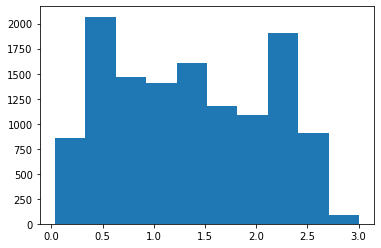

In [47]:
plt.hist(preds.detach())

(array([2306.,    0.,    0., 5016.,    0.,    0., 4738.,    0.,    0.,
         494.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

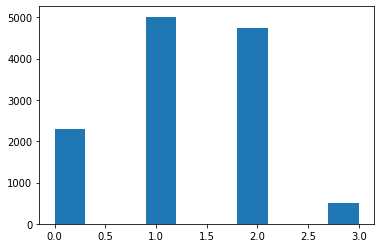

In [37]:
plt.hist(preds.round().detach())

(array([6293.,    0.,    0.,    0.,    0., 3457.,    0.,    0.,    0.,
        2804.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

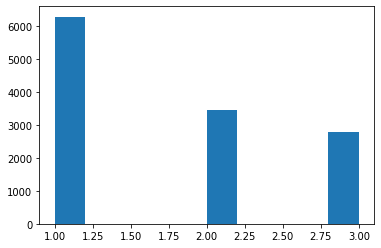

In [38]:
plt.hist(test_data[1].squeeze())

In [39]:
test_prediction_analysis = pd.DataFrame({'user':test_data[0][:,0].numpy(), 'item': test_data[0][:, 1].numpy(),'predicted': preds.round().detach().long().numpy(), 
                                         'actual': test_data[1].squeeze().long().numpy()})


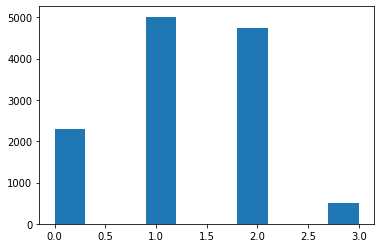

In [40]:
plt.hist(test_prediction_analysis['predicted'])
plt.show()

In [41]:
test_prediction_analysis.predicted.unique()

array([1, 2, 0, 3])

In [42]:
test_prediction_analysis.to_csv('test_prediction_analysis-eComm.csv', index=False)

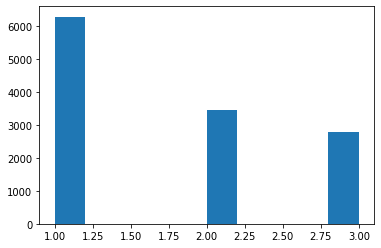

In [43]:
plt.hist(test_prediction_analysis['actual'])
plt.show()

In [35]:
test_prediction_analysis.actual.unique()

array([2, 1, 3])

In [36]:
RMSE(preds.data.numpy(), np.ones(35269)*-0.5)

0.08251564317460572

In [37]:
test_pred_df = pd.read_csv('test_prediction_analysis-yelp.csv')

In [38]:
RMSE(test_pred_df['predicted'].values, np.ones(10485)*3)

0.9895495909464561

In [39]:
reward_function = PMF(n_users=NUM_USERS, n_items=NUM_ITEMS, n_factors=embedding_feature_size, no_cuda=use_cuda)

In [40]:
reward_function.load_state_dict(torch.load('dataset/data_runs/ratio_0.800000_bs_1024_e_25_wd_0.100000_lr_0.000100_trained_pmf.pt'))
 
# Freeze all the parameters in the network
for param in reward_function.parameters():
    param.requires_grad = False
print("Initialized PMF, imported weights, created reward_function")
 
# Extract embeddings
user_embeddings = reward_function.user_embeddings.weight.data
item_embeddings = reward_function.item_embeddings.weight.data

Initialized PMF, imported weights, created reward_function


In [41]:
user_embeddings.shape

torch.Size([1037, 100])

In [42]:
item_embeddings.shape

torch.Size([24073, 100])

In [51]:
from sklearn.manifold import TSNE

In [52]:
tsne = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(item_embeddings)

In [53]:
tsne.shape

(24073, 2)

In [54]:
data_df.head(2)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,cat_1,cat_2,user_id_num,product_id_num,behavior
0,1569888759000000000,view,1003769,2053013555631882655,electronics.smartphone,huawei,463.07,537949394,4f2a5505-580d-4332-bfde-e76f27c60452,electronics,smartphone,671,191,1
1,1569888805000000000,view,1004246,2053013555631882655,electronics.smartphone,apple,736.18,537949394,4f2a5505-580d-4332-bfde-e76f27c60452,electronics,smartphone,671,380,1


In [61]:
product_details = data_df[['product_id_num', 'product_id', 'cat_1', 'cat_2']].sort_values(by='product_id_num').drop_duplicates().reset_index(drop=True)

In [64]:
product_details['0'] =  tsne[:, 0]

In [65]:
product_details['1'] =  tsne[:, 1]

In [66]:
product_details.head(2)

,product_id_num,product_id,cat_1,cat_2,0,1
0,0,1000978,electronics,smartphone,-15.440821,-8.376612
1,1,1001588,electronics,smartphone,-11.953540,-26.938566


In [72]:
product_details.cat_2.nunique()

56

In [75]:
import seaborn as sns

<AxesSubplot:xlabel='0', ylabel='1'>

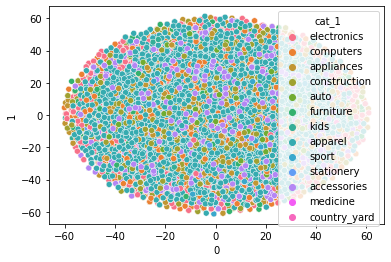

In [76]:
sns.scatterplot(data=product_details, x='0', y='1', hue='cat_1')

<AxesSubplot:xlabel='0', ylabel='1'>

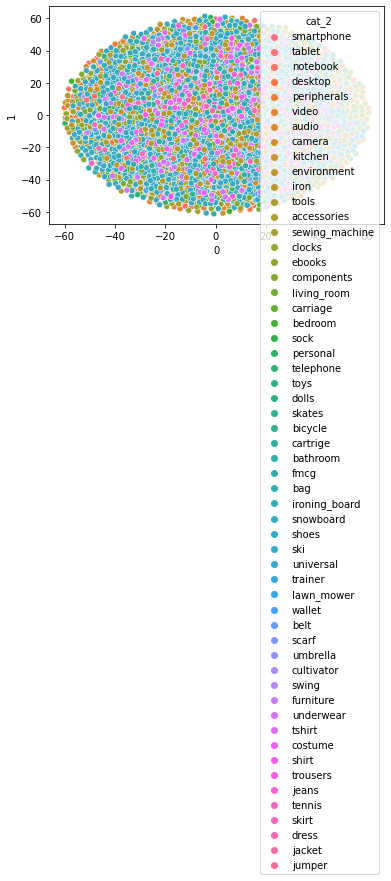

In [77]:
sns.scatterplot(data=product_details, x='0', y='1', hue='cat_2')